In [1]:
from sklearn.preprocessing import StandardScaler

from influxdb.commands import InfluxDBQueries, DataProcessor
import warnings
import pandas as pd
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
df_train = InfluxDBQueries.get_data_from_influx(groupby_time='5m', pair='BTCUSDT', start="2023-01-01T01:00:00Z",stop="2025-01-01T01:00:00Z")

In [3]:
df_test = InfluxDBQueries.get_data_from_influx(groupby_time='5m', pair='BTCUSDT', start="2025-01-01T01:00:00Z", stop="2025-04-01T01:00:00Z")

In [4]:
df_combined = pd.concat([df_train, df_test])
original_idx = df_train.shape[0]

In [5]:
df_combined, scaler, columns = DataProcessor.add_features(df_combined)

In [6]:
df_train = df_combined.iloc[:original_idx]
df_test = df_combined.iloc[original_idx:]

In [7]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [8]:
X_train, y_train = DataProcessor.make_sequences(df_train, columns_to_select=columns, window_size=288, forecast_horizon=12)

In [9]:
from influxdb.commands import LSTMModel

In [10]:
X_train.shape

(210122, 288, 29)

Based on the previous cells in the notebook, I can see that `X_train.shape` would reveal the correct shape for the input. Looking at how the data is processed, I need to match the shape with the columns used in the LSTM model.



In [11]:
lstm_forecaster = LSTMModel(input_shape=(288, len(columns)), output_steps=12, lstm_units=30)

In [12]:
lstm_forecaster.fit(X_train, y_train, epochs=100, batch_size=128, patience=6)

Training started with EarlyStopping (patience=6)...
Epoch 1/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 400s 242ms/step - loss: 0.0956 - mae: 0.2049
Epoch 2/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 404s 246ms/step - loss: 0.0113 - mae: 0.0796
Epoch 3/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 414s 252ms/step - loss: 0.0076 - mae: 0.0646
Epoch 4/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 431s 263ms/step - loss: 0.0063 - mae: 0.0582
Epoch 5/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 445s 271ms/step - loss: 0.0054 - mae: 0.0538
Epoch 6/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 444s 271ms/step - loss: 0.0047 - mae: 0.0500
Epoch 7/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 445s 271ms/step - loss: 0.0044 - mae: 0.0483
Epoch 8/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 444s 270ms/step - loss: 0.0040 - mae: 0.0457
Epoch 9/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 442s 269ms/step - loss: 0.0037 - mae: 0.0437
Epoch 10/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 446s 271ms/step - loss: 0.0035 - mae: 0.0427
Epoch 11/100
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 426s 260ms/step - loss:

In [13]:
X_test, y_test = DataProcessor.make_sequences(df_test, columns_to_select=columns, window_size=288, forecast_horizon=12)

In [14]:
X_test.shape

(25333, 288, 29)

In [15]:
pred = lstm_forecaster.predict(X_test)

792/792 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step


In [16]:
pred[-1]

array([[1.1867127],
       [1.1860316],
       [1.1857021],
       [1.1838851],
       [1.1839926],
       [1.1845685],
       [1.1840829],
       [1.1845539],
       [1.1838605],
       [1.1831824],
       [1.1823989],
       [1.1829565]], dtype=float32)

In [17]:
df_test_pred = df_test

In [18]:
df_test_pred = df_test.iloc[:12]

In [19]:
df_test_pred['close'] = pred[0]

In [20]:
df_test_pred[columns] = scaler.inverse_transform(df_test_pred[columns])

In [21]:
df_test_pred

,low,close,volume,open,high,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,...,ma_30,rsi_14,bb_mean_20,bb_std_20,bb_hband,bb_lband,macd,macd_signal,atr,obv
time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 01:05:00+00:00,94105.20,93277.326857,40.18217,94401.13,94408.72,94401.14,94260.00,93977.97,93885.01,93909.03,...,93735.334333,66.281937,93782.8435,253.893446,94290.630391,93275.056609,129.821193,63.668714,171.833571,174037.05385
2025-01-01 01:10:00+00:00,93880.00,93252.010963,182.43275,94118.41,94118.41,94118.41,94401.14,94260.00,93977.97,93885.01,...,93745.643333,66.927278,93799.3615,260.993607,94321.348714,93277.374286,127.205017,76.375974,181.650000,173854.62110
2025-01-01 01:15:00+00:00,94061.40,93242.103702,41.02326,94061.41,94172.00,94061.41,94118.41,94401.14,94260.00,93977.97,...,93758.007333,67.075161,93829.7125,265.243745,94360.199989,93299.225011,131.015991,87.303978,177.789286,173895.64436
2025-01-01 01:20:00+00:00,93971.28,93181.899885,17.31292,94153.05,94153.05,94153.05,94061.41,94118.41,94401.14,94260.00,...,93764.843333,62.367653,93856.0115,252.889766,94361.791031,93350.231969,119.521045,93.747391,185.200000,173878.33144
2025-01-01 01:25:00+00:00,93850.39,93190.448264,30.79142,93990.23,93990.89,93990.24,94153.05,94061.41,94118.41,94401.14,...,93777.220667,57.598980,93876.3745,237.892507,94352.159514,93400.589486,101.805163,95.358945,183.295714,173847.54002
2025-01-01 01:30:00+00:00,93819.60,93202.854788,46.79582,93898.14,93935.27,93898.13,93990.24,94153.05,94061.41,94118.41,...,93788.454667,50.968119,93890.4430,225.214517,94340.872034,93440.013966,80.999898,92.487136,175.479286,173800.74420
2025-01-01 01:35:00+00:00,93825.86,93189.059452,35.75370,93825.86,93989.37,93825.86,93898.13,93990.24,94153.05,94061.41,...,93806.873000,57.140642,93906.6065,218.314936,94343.236372,93469.976628,75.293096,89.048328,173.570000,173836.49790
2025-01-01 01:40:00+00:00,93893.29,93208.251402,26.00663,93970.23,93970.24,93970.23,93825.86,93898.13,93990.24,94153.05,...,93816.407000,54.886080,93923.9070,203.975912,94331.858823,93515.955177,66.117304,84.462123,176.145000,173810.49127
2025-01-01 01:45:00+00:00,93917.21,93175.754989,7.54626,93922.01,93971.02,93922.01,93970.23,93825.86,93898.13,93990.24,...,93823.426333,51.324298,93937.0040,194.404931,94325.813863,93548.194137,58.264962,79.222691,165.575714,173818.03753


In [22]:
df_test[columns] = scaler.inverse_transform(df_test[columns])

In [23]:
df_test

,low,close,volume,open,high,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,...,ma_30,rsi_14,bb_mean_20,bb_std_20,bb_hband,bb_lband,macd,macd_signal,atr,obv
time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 01:05:00+00:00,94105.20,94118.41,40.18217,94401.13,94408.72,94401.14,94260.00,93977.97,93885.01,93909.03,...,93735.334333,66.281937,93782.8435,253.893446,94290.630391,93275.056609,129.821193,63.668714,171.833571,174037.05385
2025-01-01 01:10:00+00:00,93880.00,94061.41,182.43275,94118.41,94118.41,94118.41,94401.14,94260.00,93977.97,93885.01,...,93745.643333,66.927278,93799.3615,260.993607,94321.348714,93277.374286,127.205017,76.375974,181.650000,173854.62110
2025-01-01 01:15:00+00:00,94061.40,94153.05,41.02326,94061.41,94172.00,94061.41,94118.41,94401.14,94260.00,93977.97,...,93758.007333,67.075161,93829.7125,265.243745,94360.199989,93299.225011,131.015991,87.303978,177.789286,173895.64436
2025-01-01 01:20:00+00:00,93971.28,93990.24,17.31292,94153.05,94153.05,94153.05,94061.41,94118.41,94401.14,94260.00,...,93764.843333,62.367653,93856.0115,252.889766,94361.791031,93350.231969,119.521045,93.747391,185.200000,173878.33144
2025-01-01 01:25:00+00:00,93850.39,93898.13,30.79142,93990.23,93990.89,93990.24,94153.05,94061.41,94118.41,94401.14,...,93777.220667,57.598980,93876.3745,237.892507,94352.159514,93400.589486,101.805163,95.358945,183.295714,173847.54002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-01 00:40:00+00:00,82543.27,82725.57,40.79573,82597.65,82725.58,82597.65,82640.00,82643.76,82596.36,82483.49,...,82479.795333,69.792869,82539.2890,95.877346,82731.043693,82347.534307,39.468001,14.814042,123.721429,146437.59591
2025-04-01 00:45:00+00:00,82631.54,82727.18,23.50764,82725.58,82735.09,82725.57,82597.65,82640.00,82643.76,82596.36,...,82490.030000,67.116716,82549.6800,104.479474,82758.638949,82340.721051,47.424989,21.336231,120.861429,146461.10355
2025-04-01 00:50:00+00:00,82669.33,82708.70,32.46312,82727.18,82777.97,82727.18,82725.57,82597.65,82640.00,82643.76,...,82503.126000,63.775245,82557.2135,110.378730,82777.970960,82336.456040,51.644453,27.397876,120.015714,146428.64043


In [30]:
import matplotlib.pyplot as plt

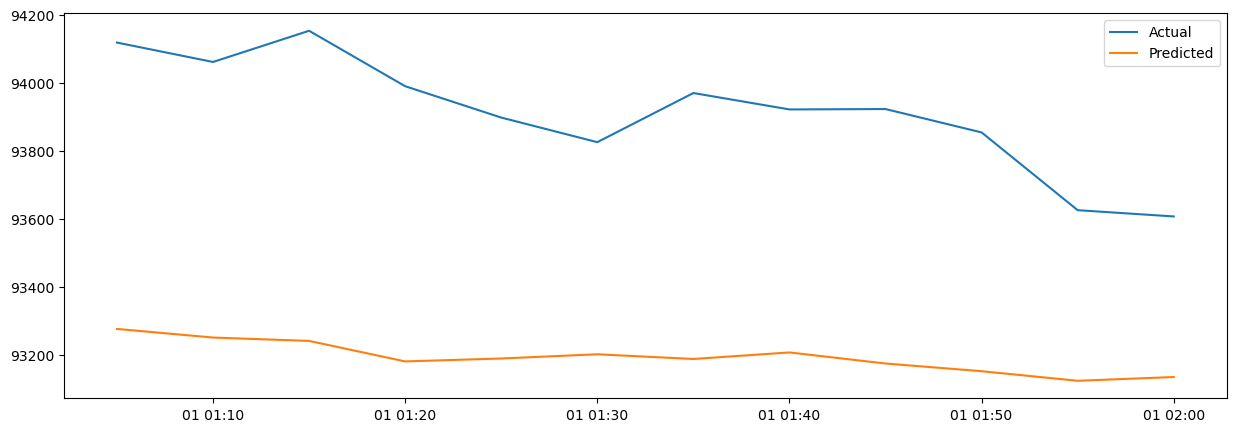

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(df_test.iloc[:12]['close'], label='Actual')
plt.plot(df_test_pred['close'], label='Predicted')
plt.legend()